# Part I: Data Preparation and Analysis

## Add all necessary imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error

## Load the datasets

In [33]:
train_data = pd.read_csv('./dataset_Seminar4/train_data.csv')
test_data = pd.read_csv('./dataset_Seminar4/test_data.csv')

train_data.describe()


,LocationNumber,RSSI,TxLinkSpeed,RxLinkSpeed,MainAPConnect,TxThroughput,AvgPingLatency
count,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000
mean,18.151161,-62.364212,491.264874,460.954107,0.913958,12.988920,54.771372
std,10.338002,9.442463,240.868700,251.600115,0.280430,4.413973,8.735672
min,1.000000,-79.040000,33.240000,-12.530000,0.000000,0.780000,39.300000
25%,9.000000,-70.360000,273.200000,249.127500,1.000000,11.320000,48.940000
50%,18.000000,-62.910000,476.635000,396.480000,1.000000,14.790000,52.290000
75%,27.000000,-53.790000,664.390000,656.422500,1.000000,15.980000,57.470000
max,36.000000,-37.020000,905.390000,911.000000,1.000000,19.160000,96.550000


## Make plots to understand the data

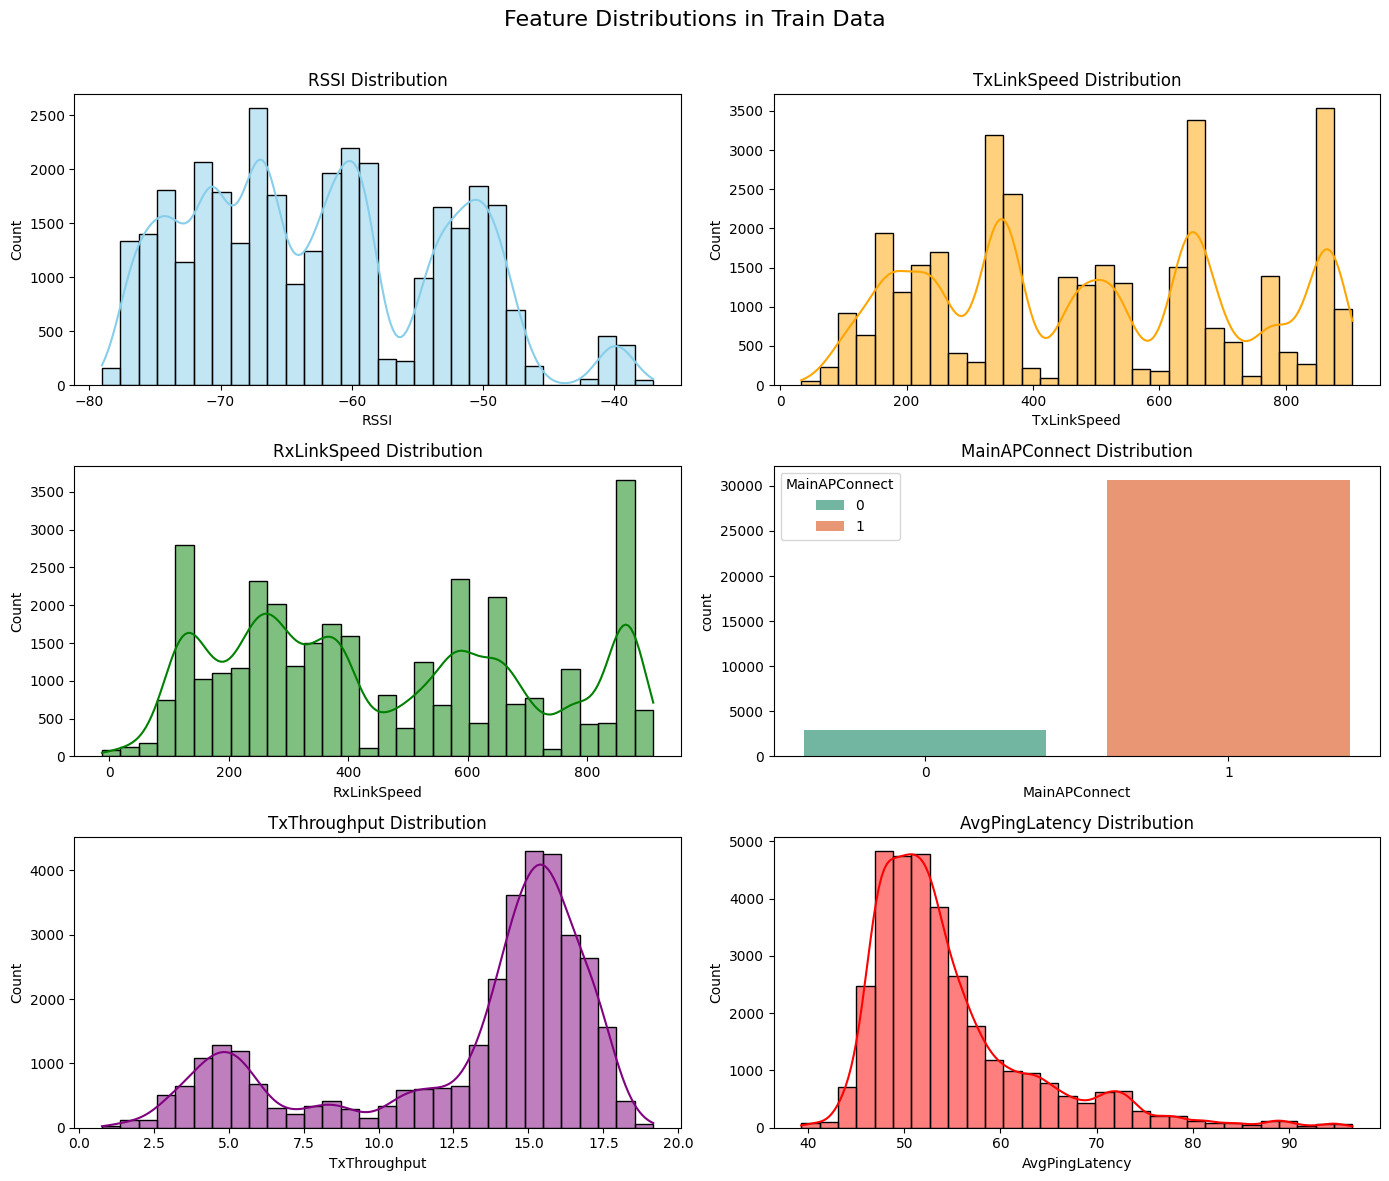

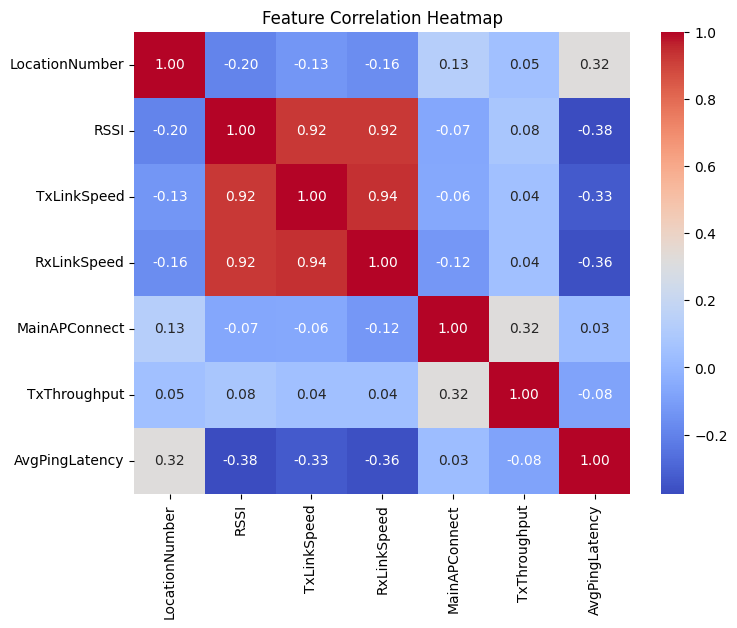

In [34]:
# For this we will one use the train_data.csv file as the test_data.csv file should be distributed similarly to the train one.

# Plot the distribution of each feature
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Feature Distributions in Train Data', fontsize=16)

# RSSI
sns.histplot(train_data['RSSI'], bins=30, kde=True, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('RSSI Distribution')

# TxLinkSpeed
sns.histplot(train_data['TxLinkSpeed'], bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('TxLinkSpeed Distribution')

# RxLinkSpeed
sns.histplot(train_data['RxLinkSpeed'], bins=30, kde=True, ax=axs[1, 0], color='green')
axs[1, 0].set_title('RxLinkSpeed Distribution')

# MainAPConnect
sns.countplot(x='MainAPConnect', data=train_data, ax=axs[1, 1], palette='Set2', hue='MainAPConnect')
axs[1, 1].set_title('MainAPConnect Distribution')

# TxThroughput
sns.histplot(train_data['TxThroughput'], bins=30, kde=True, ax=axs[2, 0], color='purple')
axs[2, 0].set_title('TxThroughput Distribution')

# AvgPingLatency
sns.histplot(train_data['AvgPingLatency'], bins=30, kde=True, ax=axs[2, 1], color='red')
axs[2, 1].set_title('AvgPingLatency Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

Correlation of features with TxThroughput:
LocationNumber    0.046687
RSSI              0.076853
TxLinkSpeed       0.044451
RxLinkSpeed       0.044280
MainAPConnect     0.321010
Name: TxThroughput, dtype: float64

Correlation of features with AvgPingLatency:
LocationNumber    0.322541
RSSI             -0.375971
TxLinkSpeed      -0.331170
RxLinkSpeed      -0.361945
MainAPConnect     0.028982
Name: AvgPingLatency, dtype: float64


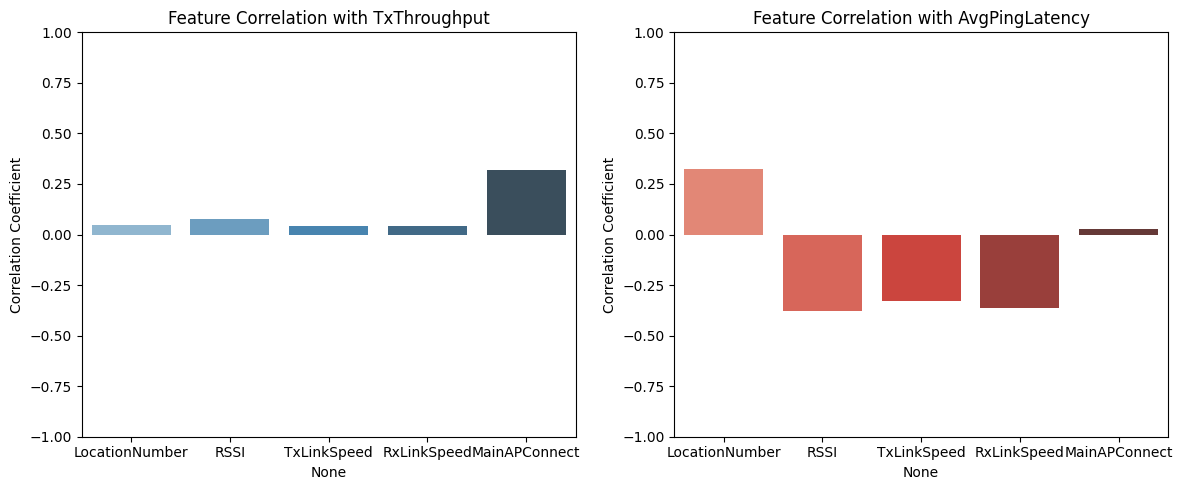

In [35]:
# Correlation analysis between features and performance metrics (TxThroughput, AvgPingLatency)

# Select relevant columns
feature_cols = ['LocationNumber', 'RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'MainAPConnect']
performance_cols = ['TxThroughput', 'AvgPingLatency']

# Compute correlation matrix between features and performance metrics
corr_matrix = train_data[feature_cols + performance_cols].corr()

# Extract correlations of features with performance metrics
corr_with_throughput = corr_matrix['TxThroughput'][feature_cols]
corr_with_latency = corr_matrix['AvgPingLatency'][feature_cols]

# Display the correlations
print("Correlation of features with TxThroughput:")
print(corr_with_throughput)
print("\nCorrelation of features with AvgPingLatency:")
print(corr_with_latency)

# Visualize correlations as bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=corr_with_throughput.index, y=corr_with_throughput.values, ax=axs[0], palette='Blues_d', hue=corr_with_throughput.index)
axs[0].set_title('Feature Correlation with TxThroughput')
axs[0].set_ylabel('Correlation Coefficient')
axs[0].set_ylim(-1, 1)

sns.barplot(x=corr_with_latency.index, y=corr_with_latency.values, ax=axs[1], palette='Reds_d', hue=corr_with_latency.index)
axs[1].set_title('Feature Correlation with AvgPingLatency')
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_ylim(-1, 1)

plt.tight_layout()
plt.show()



# Part II: FNN-based performance prediction

## Feature Selection

In [36]:
""""
From what we have observed with the correlation analysis, 
we can see that the features that have the most correlation with the 
AvgPingLatency are:
- RSSI
- TxLinkSpeed
- RxLinkSpeed
- LocationNumber 

Also for TxThroughput we can see that the features that 
have the most correlation are:
- RSSI (is pretty low but still has more influence than the other features)
- MainAPConnect

"""

'"\nFrom what we have observed with the correlation analysis, \nwe can see that the features that have the most correlation with the \nAvgPingLatency are:\n- RSSI\n- TxLinkSpeed\n- RxLinkSpeed\n- LocationNumber \n\nAlso for TxThroughput we can see that the features that \nhave the most correlation are:\n- RSSI (is pretty low but still has more influence than the other features)\n- MainAPConnect\n\n'

## Data preparation and preprocessing

In [37]:
"""
Data preprocessing and FNN model setup for WiFi performance prediction using PyTorch.

Steps:
1. Handle missing values
2. Feature scaling using StandardScaler
3. Split data into train/validation (test_data reserved for final evaluation)
4. Build two FNN architectures (PyTorch): one for Throughput, one for AvgPingLatency
"""

print(train_data.isnull().sum()) # No missing values

# Prepare features and targets
# Throughput prediction
X_throughput = train_data[['RSSI', 'MainAPConnect']].copy()
y_throughput = train_data['TxThroughput']

# Latency prediction
X_latency = train_data[['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'LocationNumber']].copy()
y_latency = train_data['AvgPingLatency']


# Feature scaling
scaler_throughput = StandardScaler()
X_throughput_scaled = scaler_throughput.fit_transform(X_throughput)

scaler_latency = StandardScaler()
X_latency_scaled = scaler_latency.fit_transform(X_latency)

# Split into train/validation sets (test_data is reserved for final evaluation)
X_throughput_train, X_throughput_val, y_throughput_train, y_throughput_val = train_test_split(
    X_throughput_scaled, y_throughput, test_size=0.2, random_state=42
)
X_latency_train, X_latency_val, y_latency_train, y_latency_val = train_test_split(
    X_latency_scaled, y_latency, test_size=0.2, random_state=42
)




# Convert to PyTorch tensors
X_throughput_train = torch.tensor(X_throughput_train, dtype=torch.float32)
X_throughput_val = torch.tensor(X_throughput_val, dtype=torch.float32)
y_throughput_train = torch.tensor(y_throughput_train.values, dtype=torch.float32).view(-1, 1)
y_throughput_val = torch.tensor(y_throughput_val.values, dtype=torch.float32).view(-1, 1)

X_latency_train = torch.tensor(X_latency_train, dtype=torch.float32)
X_latency_val = torch.tensor(X_latency_val, dtype=torch.float32)
y_latency_train = torch.tensor(y_latency_train.values, dtype=torch.float32).view(-1, 1)
y_latency_val = torch.tensor(y_latency_val.values, dtype=torch.float32).view(-1, 1)

LocationNumber    0
RSSI              0
TxLinkSpeed       0
RxLinkSpeed       0
MainAPConnect     0
TxThroughput      0
AvgPingLatency    0
dtype: int64


## FNN model setup for WiFi performance prediction using PyTorch

In [38]:
# Define FNN architectures using PyTorch
class FNNThroughput(nn.Module):
    def __init__(self, input_dim):
        super(FNNThroughput, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)


class FNNLatency(nn.Module):
    def __init__(self, input_dim):
        super(FNNLatency, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)

## Model training and evaluation

Training FNNThroughput...
Epoch 1/100 - Train Loss: 104.5138 - Val Loss: 23.8178
Epoch 10/100 - Train Loss: 16.9451 - Val Loss: 17.5997
Epoch 20/100 - Train Loss: 16.8711 - Val Loss: 17.5415
Epoch 30/100 - Train Loss: 16.8371 - Val Loss: 17.5070
Epoch 40/100 - Train Loss: 16.8239 - Val Loss: 17.4871
Epoch 50/100 - Train Loss: 16.8142 - Val Loss: 17.4646
Epoch 60/100 - Train Loss: 16.8012 - Val Loss: 17.4602
Epoch 70/100 - Train Loss: 16.7748 - Val Loss: 17.4336
Epoch 80/100 - Train Loss: 16.7508 - Val Loss: 17.4166
Epoch 90/100 - Train Loss: 16.7540 - Val Loss: 17.4144
Epoch 100/100 - Train Loss: 16.7352 - Val Loss: 17.3883

Training FNNLatency...
Epoch 1/100 - Train Loss: 2548.9279 - Val Loss: 1343.1375
Epoch 10/100 - Train Loss: 50.7956 - Val Loss: 49.7029
Epoch 20/100 - Train Loss: 45.2433 - Val Loss: 44.5219
Epoch 30/100 - Train Loss: 41.9940 - Val Loss: 41.3535
Epoch 40/100 - Train Loss: 39.8124 - Val Loss: 39.7114
Epoch 50/100 - Train Loss: 38.3091 - Val Loss: 37.7757
Epoch 60/10

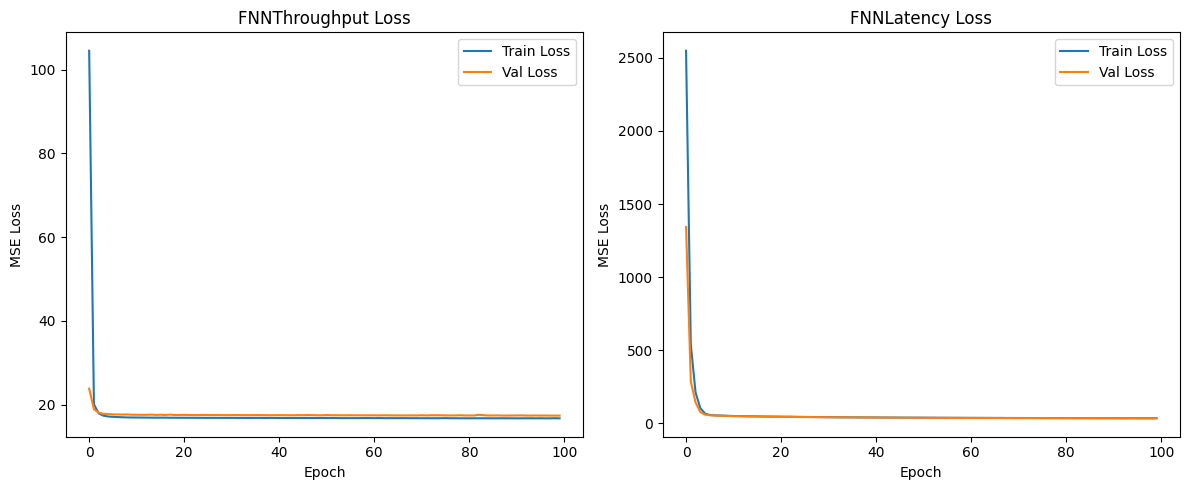

In [39]:
# Training approach:
# - We'll train both FNNThroughput and FNNLatency for 100 epochs.
# - We'll use a batch size of 128.
# - After each epoch, we'll evaluate and print the validation loss.
# - We'll store the training and validation loss history for plotting.

# Instantiate models
fnn_throughput = FNNThroughput(X_throughput_train.shape[1])
fnn_latency = FNNLatency(X_latency_train.shape[1])

# Example: define loss and optimizer (for training later)
loss_fn = nn.MSELoss()
optimizer_throughput = optim.Adam(fnn_throughput.parameters(), lr=0.001)
optimizer_latency = optim.Adam(fnn_latency.parameters(), lr=0.001)




# Hyperparameters
epochs = 100
batch_size = 128

# DataLoaders
train_throughput_ds = TensorDataset(X_throughput_train, y_throughput_train)
val_throughput_ds = TensorDataset(X_throughput_val, y_throughput_val)
train_latency_ds = TensorDataset(X_latency_train, y_latency_train)
val_latency_ds = TensorDataset(X_latency_val, y_latency_val)

train_throughput_loader = DataLoader(train_throughput_ds, batch_size=batch_size, shuffle=True)
val_throughput_loader = DataLoader(val_throughput_ds, batch_size=batch_size)
train_latency_loader = DataLoader(train_latency_ds, batch_size=batch_size, shuffle=True)
val_latency_loader = DataLoader(val_latency_ds, batch_size=batch_size)

def train_model(model, optimizer, train_loader, val_loader, loss_fn, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward() # Backpropagation 
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = loss_fn(preds, yb)
                val_loss += loss.item() * xb.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

print("Training FNNThroughput...")
throughput_train_losses, throughput_val_losses = train_model(
    fnn_throughput, optimizer_throughput, train_throughput_loader, val_throughput_loader, loss_fn, epochs
)

print("\nTraining FNNLatency...")
latency_train_losses, latency_val_losses = train_model(
    fnn_latency, optimizer_latency, train_latency_loader, val_latency_loader, loss_fn, epochs
)

# Plot training and validation loss curves

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(throughput_train_losses, label='Train Loss')
plt.plot(throughput_val_losses, label='Val Loss')
plt.title('FNNThroughput Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latency_train_losses, label='Train Loss')
plt.plot(latency_val_losses, label='Val Loss')
plt.title('FNNLatency Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model evaluation using the test set

In [41]:
# Evaluate FNNThroughput and FNNLatency on the test set using test_data
# Prepare test features and targets for throughput and latency


test_features = test_data[['RSSI', 'MainAPConnect', 'TxLinkSpeed', 'RxLinkSpeed', 'LocationNumber']].values.astype(np.float32)
test_throughput_targets = test_data['TxThroughput'].values.astype(np.float32).reshape(-1, 1)
test_latency_targets = test_data['AvgPingLatency'].values.astype(np.float32).reshape(-1, 1)

# Convert to torch tensors
test_features_tensor = torch.from_numpy(test_features)
test_throughput_targets_tensor = torch.from_numpy(test_throughput_targets)
test_latency_targets_tensor = torch.from_numpy(test_latency_targets)

# Set models to evaluation mode
fnn_throughput.eval()
fnn_latency.eval()

# Helper function to evaluate model on numpy arrays/tensors
def evaluate_model_on_data(model, features_tensor, targets_tensor, loss_fn, batch_size=128):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    num_samples = features_tensor.shape[0]
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            xb = features_tensor[i:i+batch_size]
            yb = targets_tensor[i:i+batch_size]
            out = model(xb)
            loss = loss_fn(out, yb)
            test_loss += loss.item() * xb.size(0)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())
    test_loss /= num_samples
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return test_loss, preds, trues

# Evaluate throughput model
throughput_test_loss, throughput_preds, throughput_trues = evaluate_model_on_data(
    fnn_throughput, test_features_tensor, test_throughput_targets_tensor, loss_fn
)

# Evaluate latency model
latency_test_loss, latency_preds, latency_trues = evaluate_model_on_data(
    fnn_latency, test_features_tensor, test_latency_targets_tensor, loss_fn
)

print(f"Test MSE Loss for FNNThroughput: {throughput_test_loss:.4f}")
print(f"Test MSE Loss for FNNLatency: {latency_test_loss:.4f}")

throughput_mae = mean_absolute_error(throughput_trues, throughput_preds)
latency_mae = mean_absolute_error(latency_trues, latency_preds)

print(f"Test MAE for FNNThroughput: {throughput_mae:.4f}")
print(f"Test MAE for FNNLatency: {latency_mae:.4f}")

# Visualize predictions vs true values
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(throughput_trues, throughput_preds, alpha=0.3)
plt.xlabel("True Throughput")
plt.ylabel("Predicted Throughput")
plt.title("FNNThroughput: True vs Predicted")

plt.subplot(1,2,2)
plt.scatter(latency_trues, latency_preds, alpha=0.3, color='orange')
plt.xlabel("True Latency")
plt.ylabel("Predicted Latency")
plt.title("FNNLatency: True vs Predicted")

plt.tight_layout()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x5 and 2x32)